# The Wine bar project 

### Introduction & Business problem

In case my career as Data scientist fails (*let's hope it doesn't*), I want to open a wine bar in Paris, France. <br/> 
Of course wine, **I'm french !** <br/>

The problem is that, from my experience, Paris has multiple areas where people go out for a drink and these areas are not concentrated but rather spread around the city. <br/>

Therefore, where is the best location to open a new wine bar to ensure enough clients to be successful ? <br/>

To ensure success, I need the bar to be in a location where the concentration of venues such as theaters, cinemas, restaurants demonstrates an active life in the area. Using the Foursquare data, I will geolocate the venues and find the best spot to open my wine bar.

### Data section

To provide an analytical answer to the business problem of where to open my future wine bar in Paris I will do :<br/>
- A segmentation of Paris inner-city using a .geojson file : available here <a href="https://www.data.gouv.fr/fr/datasets/arrondissements-1/">data.gouv</a>
- Venues data related to the neighborhoods using Foursquare API (Category of the venue, customer rating, ...)

### Methodology

In order to find the right spot to open our wine bar, we will proceed as follow :
- We will import Paris neighborhoods coordinates from a geojson file and place the markers on a map
- We will use the Foursquare API to retrieve venues based on the *Night life* and *Culture and leisure* categories
- We will also identify the number of wine bars in each neighborhood to analyse the comptetitors based on the density
- From these results, we will use the **K-mean clustering** method to find identify different types of neighborhoods based on the kind of cultural sites and night life venues that they offer
- Finally, we will display a choropleth map highlighting the density of wine bars in Paris and with the identified clusers as markers

In [1]:
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance
from math import sqrt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#### Loading the Paris coordinates

From a .geojson file *arrondissements.geojson* from available the French national open data web site <a href="https://www.data.gouv.fr/fr/datasets/arrondissements-1/">data.gouv</a> website, we will first display a map of Paris, France and place markers on the centers of each of Paris' 20 neighborhoods (*arrondissments*).

We fill the DataFrame *dfparis* with data from the .geojson file.

In [2]:
with open('arrondissements.geojson') as json_data:
    parisarr = json.load(json_data)
    
par_data = parisarr['features']
colnames = ['PostCode', 'Neighborhood', 'Latitude', 'Longitude']
dfparis = pd.DataFrame(columns=colnames)

for d in par_data: 
    latlon = d['properties']['geom_x_y']
    code = d['properties']['c_ar']    
    neigh = d['properties']['l_aroff']
    
    lat = latlon[0]
    lon = latlon[1]
    dfparis= dfparis.append({'PostCode' : code, 'Neighborhood' : neigh, 'Latitude' : lat, 'Longitude' : lon}, ignore_index=True)   

dfparis = dfparis.sort_values('PostCode')
dfparis.reset_index(drop=True, inplace=True)
dfparis

,PostCode,Neighborhood,Latitude,Longitude
0,1,Louvre,48.862563,2.336443
1,2,Bourse,48.868279,2.342803
2,3,Temple,48.862872,2.360001
3,4,Hôtel-de-Ville,48.854341,2.357630
4,5,Panthéon,48.844443,2.350715
5,6,Luxembourg,48.849130,2.332898
6,7,Palais-Bourbon,48.856174,2.312188
7,8,Élysée,48.872721,2.312554
8,9,Opéra,48.877164,2.337458
9,10,Entrepôt,48.876130,2.360728


Paris' 20 arrondissements (Neighborhoods) are now available in pandas DataFrame **dfparis**

Now to vizualise the neighborhoods, we will retrieve the Paris central coordinates.

In [3]:
#Getting the coordinates of Paris to correctly center the map
address = 'Paris, France'

geolocator = Nominatim(user_agent="par_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


#### Creation of a map of Paris, using Follium

In [4]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfparis['Latitude'], dfparis['Longitude'], dfparis['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

The above map shows a detailed map of Paris' neighborhoods.

In [5]:
df_coor = dfparis[['Latitude', 'Longitude']]
dfparis['Distance from center'] = ''

In [6]:
#Function to calculate the distance of center coordinates of each neighborgood to the center of Paris
def calc_xy_distance(coords_1, coords_2):
    return geopy.distance.vincenty(coords_1, coords_2).m

In [7]:
for i in range(0, len(df_coor)):
    dfparis['Distance from center'][i] = calc_xy_distance((df_coor['Latitude'][i], df_coor['Longitude'][i]), (latitude, longitude))

C:\Users\hantu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hantu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now let's identify the venues around each of these center coordinates of the city using the **Foursquare API**.

### Foursquare

Let's use Foursquare API to get info on wine bars in each neighborhood.<br/>

We're interested in venues from the **Night life**, the **Culture and leisure** and the **Wine bar** categories. The density will indicate the activity of the area: it will show the areas where tourists make visits (cultural places) and also where locals and tourists go during night time. <br/>
We are interested in areas where there is a good density of bars, nightclubs and pubs but less wine bars (less competitors).

Let's send a query to retrieve the venues using Foursquare API. To do so, we will send a query to Foursquare for each Paris' neighborhood coordinates and look for venues in the three selected categories : *Night life*, *Culture and leisure* and *Wine bars*. <br/>
**Night life** category includes venues like :
- Bars
- Cocktail bars
- Whisky bars
- Lounge
- etc...

**Culture and leisure** category includes venues like :
- Art gallery
- Casino
- Theater
- Concert venue
- Aquarium
- Cinema
- Museums
- etc...

Finally, the **Wine bar** category is a sub category itself. <br/>
We use this last category to isolate the results in each neighborhood to evaluate the density.


In [10]:
# Category IDs corresponding to Night life, Culture and leisure and Wine bar were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):
all_categ = ['4d4b7105d754a06376d81259', '4bf58dd8d48988d123941735', '4d4b7104d754a06370d81259'] 
#Night life , #Wine bar category, #Culture and leisure

In [11]:
wine_bars, nightlife_venues, cultural_venues = {}, {}, {}

In [12]:
def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', France', '')
    return address


def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=300, limit=100):
    version = '20180724'
    
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']        
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues



def get_venues(dfparis, category, wine_bars=wine_bars, nightlife_venues=nightlife_venues, cultural_venues=cultural_venues):   
    for i in range(0, len(dfparis)):
        lat = dfparis['Latitude'][i]
        lon = dfparis['Longitude'][i]
        nb_wine, nb_culture, nb_bar = 0, 0, 0
        
        venues = get_venues_near_location(lat, lon, category, CLIENT_ID, CLIENT_SECRET)        
    
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]        
            venue_categories = venue[2]        
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]        
            venue_bar = (venue_id, 
                         venue_name, 
                         venue_categories[0][0], 
                         venue_latlon[0], 
                         venue_latlon[1], 
                         venue_address,            
                         dfparis.loc[i, 'Neighborhood'],
                         venue_distance)

            
            if category == '4d4b7105d754a06376d81259': #nightlife
                if venue_categories[0][1] == '4bf58dd8d48988d123941735': #wine bar category
                    nb_wine = 0
                else:
                    nb_bar = nb_bar + 1
                    nightlife_venues[venue_id] = venue_bar                     
            elif category == '4d4b7104d754a06370d81259':#culture category
                cultural_venues[venue_id] = venue_bar                
                nb_culture = nb_culture +1            
            else: #wine bar category
                wine_bars[venue_id] = venue_bar
                nb_wine = nb_wine + 1 
        
        if category == '4d4b7105d754a06376d81259': #nightlife:
            dfparis.loc[i, 'Nb nightlife venues'] = nb_bar
        elif category == '4d4b7104d754a06370d81259':#culture category
            dfparis.loc[i, 'Nb cultural venues'] = nb_culture
        else:
            dfparis.loc[i, 'Nb wine bars'] = nb_wine     
        
        

#### Night life, Culture and leisure and wine bars type of venues
We create a dictionnary to isolate the venues which categories are most likely to be our competitors. <br/>
We also want to store the number of venues from each category per neighborhood in the initial dataframe dfparis.

In [13]:
for category in all_categ:    
    get_venues(dfparis, category, wine_bars=wine_bars, nightlife_venues=nightlife_venues, cultural_venues=cultural_venues)

dfparis.reset_index(drop=True, inplace=True)
dfparis.head()

,PostCode,Neighborhood,Latitude,Longitude,Distance from center,Nb nightlife venues,Nb wine bars,Nb cultural venues
0,1,Louvre,48.862563,2.336443,1280.59,11.0,3.0,17.0
1,2,Bourse,48.868279,2.342803,1436.21,32.0,7.0,7.0
2,3,Temple,48.862872,2.360001,929.653,10.0,5.0,12.0
3,4,Hôtel-de-Ville,48.854341,2.357630,522.961,16.0,5.0,9.0
4,5,Panthéon,48.844443,2.350715,1363.8,28.0,4.0,2.0


#### Now let's take a look at the results in a DataFrame 

In [14]:
#Converting dict to pd dataFrame
df_winebars = pd.DataFrame.from_dict(wine_bars, orient='index', columns=['Id', 'Name', 'Category', 'Latitude', 'Longitude', 'Adresse', 'Neighborhood', 'Distance from center'])
df_nightlifevenues = pd.DataFrame.from_dict(nightlife_venues, orient='index', columns=['Id', 'Name', 'Category', 'Latitude', 'Longitude', 'Adresse', 'Neighborhood', 'Distance from center'])
df_culturalvenues = pd.DataFrame.from_dict(cultural_venues, orient='index', columns=['Id', 'Name', 'Category', 'Latitude', 'Longitude', 'Adresse', 'Neighborhood', 'Distance from center'])
df_winebars.reset_index(drop=True, inplace=True)
df_nightlifevenues.reset_index(drop=True, inplace=True)
df_culturalvenues.reset_index(drop=True, inplace=True)

We count the number of venues per **Neighborhood**

In [15]:
count_wine = df_winebars[['Id','Neighborhood']].groupby('Neighborhood').count().sort_values('Id', ascending=False)
count_night = df_nightlifevenues[['Id', 'Neighborhood']].groupby('Neighborhood').count().sort_values('Id', ascending=False)
count_culture = df_culturalvenues[['Id', 'Neighborhood']].groupby('Neighborhood').count().sort_values('Id', ascending=False)

In [16]:
count_all = pd.concat([count_night, count_culture, count_wine], axis=1)
edit_cols = ['Nb nightlife', 'Nb culture', 'Nb wine']
count_all.columns = edit_cols
count_all.sort_values(['Nb nightlife', 'Nb culture', 'Nb wine'], ascending=(False, True, True))

C:\Users\hantu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Nb nightlife,Nb culture,Nb wine
Bourse,32,7,7.0
Panthéon,28,2,4.0
Élysée,16,5,1.0
Opéra,16,5,3.0
Hôtel-de-Ville,16,9,5.0
Louvre,11,17,3.0
Buttes-Montmartre,10,3,1.0
Temple,10,12,5.0
Popincourt,9,4,4.0
Entrepôt,6,3,NaN


The neighborhoods "Bourse", "Panthéon" and "Elysée" have the largest number of Nighlife venues. <br/>
The neighborhoods "Louvre", "Temple" and "Hotel de ville" have the largest number of Cultural venues. <br/>
The neighborhoods "Bourse", "Hotel de Ville" and "Temple" have the largest number of wine bars venues. 

These later neighborhoods will certainly not be interesting as they are competitive areas. There are probably too many bars and wine bars already.

Now we count the number of venues per **Category**

In [17]:
count_wine_cat = df_winebars[['Id','Category']].groupby('Category').count().sort_values('Id', ascending=False)
count_wine_cat.columns = ['Number of venues']
count_night_cat = df_nightlifevenues[['Id', 'Category']].groupby('Category').count().sort_values('Id', ascending=False)
count_night_cat.columns = ['Number of venues']
count_culture_cat = df_culturalvenues[['Id', 'Category']].groupby('Category').count().sort_values('Id', ascending=False)
count_culture_cat.columns = ['Number of venues']

In [18]:
count_night_cat.head(4)

,Number of venues
Category,
Bar,81
French Restaurant,16
Nightclub,15
Pub,12


In [19]:
count_culture_cat.head(4)

,Number of venues
Category,
Art Gallery,28
Theater,17
Art Museum,11
Dance Studio,9


In the **Nightlife** category, the most frequent venues are Bar, French restaurant, Nightclub and Pub. <br/>
In the **Cultural** category,  the most frequent venues are Art gallery, Theater, Art museum and Dance studio.

In [20]:
def plot_multi_bar_x(df):        
    plt.figure(figsize=(10,5))
    data = [df['Nb nightlife'], df['Nb culture'], df['Nb wine']]    
    color_list = ['b', 'r', 'g']    
    gap = .8 / len(data)
    
    for i, row in enumerate(data):
        X = np.arange(len(row))
        plt.bar(X + i * gap, row,
                width = gap,
                color = color_list[i % len(color_list)])
    
    plt.xlabel('Neighborhoods')
    plt.xticks(X+ i * gap, df.index, rotation=70)
    plt.title('Number venues per neighborhood and per category in Paris')    
    
    plt.legend(['Nightlife venues', 'Cultural venues', 'Wine bars'])
    
    plt.show()  

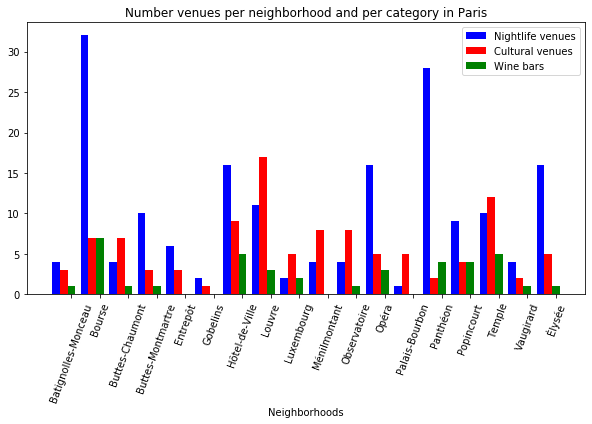

In [21]:
plot_multi_bar_x(count_all)

Bar chart showing the number of venues per neighborhoods and per category. <br/>
We see that the Nightlife venues are predominant in the city. We also find cultural venues in every location. <br/>
Nevertheless, wee see that the number of wine bars is sometimes very low or missing. <br/><br/>

Let's dig more to find out why...

#### Let's visualize these results on a map. <br/>

**In red**, you can see the location of wine bars across the city. They are mostly concentrated around the city center.<br/>
**In blue** are the other venues from the Foursquare categories "Night life" and "Culture and leisure" on a Paris Map

In [22]:
df_othervenues = pd.concat([df_nightlifevenues, df_culturalvenues])

In [23]:
# create map of Paris using latitude and longitude values
map_paris_wine = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of wine bars to map    
for lat, lng, label in zip(df_othervenues['Latitude'], df_othervenues['Longitude'], df_othervenues['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris_wine)

# add markers of wine bars to map
for lat, lng, label in zip(df_winebars['Latitude'], df_winebars['Longitude'], df_winebars['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris_wine)  


map_paris_wine

This map shows that every location where we have wine bars, we also identify groups of other venues such as cultural and nightlife venues. We can already notice that there are areas where there are cultural places and nightlife venues but no or very few wine bars : 10th arrondissement, 20th arrondissement (east), 8th arrondissment near the champs elysees and 18th arrondissement near Montmartre.

In order to dig further, we will prepare our data for a K-mean clustering method. 

**We now prepare our data for the clustering method**. <br/>
 
We swap the categories to columns in the data frame and count the frequency for each category. <br/>
Then we group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [24]:
# one hot encoding
paris_onehot = pd.get_dummies(df_othervenues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = df_othervenues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
DownT_onehot = paris_onehot[fixed_columns]

paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped

,Neighborhood,Art Gallery,Art Museum,Bar,Beer Garden,Bistro,Brasserie,Brazilian Restaurant,Brewery,Café,...,Outdoor Sculpture,Performing Arts Venue,Pub,Public Art,Restaurant,Salsa Club,Speakeasy,Sports Bar,Tapas Restaurant,Theater
0,Batignolles-Monceau,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
1,Bourse,0.025641,0.000000,0.358974,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.025641
2,Buttes-Chaumont,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.272727
3,Buttes-Montmartre,0.000000,0.000000,0.538462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.153846
4,Entrepôt,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222
5,Gobelins,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Hôtel-de-Ville,0.080000,0.040000,0.280000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.080000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Louvre,0.107143,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714
8,Luxembourg,0.142857,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Ménilmontant,0.333333,0.000000,0.166667,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333


Let's check out the 5 most common venues in each neighborhood

In [25]:
num_top_venues = 5

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Batignolles-Monceau----
         venue  freq
0          Bar  0.43
1   Salsa Club  0.14
2  Comedy Club  0.14
3  Music Venue  0.14
4        Diner  0.14


----Bourse----
               venue  freq
0                Bar  0.36
1  French Restaurant  0.15
2       Dance Studio  0.05
3                Pub  0.05
4             Lounge  0.05


----Buttes-Chaumont----
          venue  freq
0       Theater  0.27
1           Bar  0.18
2  Concert Hall  0.18
3      Dive Bar  0.09
4    Public Art  0.09


----Buttes-Montmartre----
              venue  freq
0               Bar  0.54
1           Theater  0.15
2  Tapas Restaurant  0.08
3    History Museum  0.08
4         Gastropub  0.08


----Entrepôt----
                  venue  freq
0               Theater  0.22
1                Museum  0.11
2                Lounge  0.11
3               Gay Bar  0.11
4  Fast Food Restaurant  0.11


----Gobelins----
         venue  freq
0          Bar  0.33
1      Brewery  0.33
2  Music Venue  0.33
3  Art Gallery  0.00
4 

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,Bar,Music Venue,Comedy Club,Salsa Club,Diner,Gay Bar,Gastropub,French Restaurant,Fast Food Restaurant,Exhibit
1,Bourse,Bar,French Restaurant,Cocktail Bar,Pub,Dance Studio,Lounge,Theater,Miscellaneous Shop,Bistro,Comedy Club
2,Buttes-Chaumont,Theater,Bar,Concert Hall,Public Art,Exhibit,Dive Bar,Music Venue,Brasserie,Brazilian Restaurant,Gay Bar
3,Buttes-Montmartre,Bar,Theater,French Restaurant,History Museum,Gastropub,Tapas Restaurant,Brasserie,Dive Bar,Hookah Bar,Art Museum
4,Entrepôt,Theater,Lounge,Gay Bar,Fast Food Restaurant,Latin American Restaurant,Museum,Bar,Beer Garden,Brasserie,Brazilian Restaurant


## *K-Mean* Clustering

### First we will evaluate the optimal number of clusters k

In [28]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


In [29]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [30]:
Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(paris_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Let's check the result using the "Elbow Method"

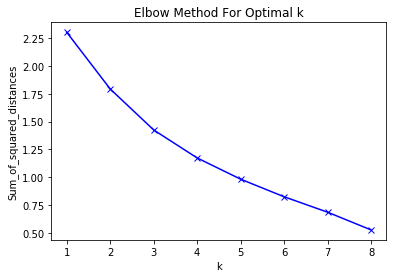

In [31]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### We can see on the above graph that the optimal k is not properly identified yet we can take 3 as the number of clusters, based on the tiny elbow it forms. <br/>
Lets define *k*-means to cluster the neighborhood into 3 clusters.

In [32]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

Merging the cluster labels with the initial Paris dataframe

In [33]:
#neighborhoods_venues_sorted= neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)


In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = dfparis

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged = paris_merged.dropna(subset=['Cluster Labels'])
paris_merged['Cluster Labels'] = paris_merged['Cluster Labels'].astype(int)

paris_merged.head()

,PostCode,Neighborhood,Latitude,Longitude,Distance from center,Nb nightlife venues,Nb wine bars,Nb cultural venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Louvre,48.862563,2.336443,1280.59,11.0,3.0,17.0,1,Nightclub,Exhibit,Art Museum,Bar,Art Gallery,Museum,Outdoor Sculpture,Theater,Public Art,Performing Arts Venue
1,2,Bourse,48.868279,2.342803,1436.21,32.0,7.0,7.0,2,Bar,French Restaurant,Cocktail Bar,Pub,Dance Studio,Lounge,Theater,Miscellaneous Shop,Bistro,Comedy Club
2,3,Temple,48.862872,2.360001,929.653,10.0,5.0,12.0,1,Art Gallery,Bar,Nightclub,Hotel Bar,French Restaurant,Dance Studio,Cocktail Bar,Museum,Gay Bar,Art Museum
3,4,Hôtel-de-Ville,48.854341,2.357630,522.961,16.0,5.0,9.0,1,Bar,Art Gallery,Beer Garden,Dance Studio,Pub,Museum,French Restaurant,Jazz Club,Lounge,Memorial Site
4,5,Panthéon,48.844443,2.350715,1363.8,28.0,4.0,2.0,2,Bar,Pub,Theater,Tapas Restaurant,Italian Restaurant,Lounge,Café,Hookah Bar,Brazilian Restaurant,Exhibit


#### Let's visualize the results on the Paris map

In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [36]:
mychart = paris_merged[['Cluster Labels', '1st Most Common Venue']]
mychart = mychart.groupby(['Cluster Labels', '1st Most Common Venue']).agg({'1st Most Common Venue': 'count'})
mychart

1st Most Common Venue
Cluster Labels 1st Most Common Venue                       
0              History Museum                             1
1              Art Gallery                                4
               Art Museum                                 1
               Bar                                        1
               Nightclub                                  2
               Theater                                    2
2              Bar                                        6
               Music Venue                                1

In [37]:
mychart.columns = ['Nb Most common venues']

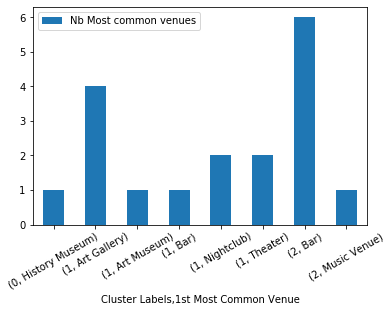

In [38]:
ax = mychart.plot.bar(rot=30)

This bar chart indicates the most common venues in each of the three clusters:<br/>
- **Cluster 0** is mostly Cultural sites with "History museum" 
- **Cluster 1** contains also lots of cultural venues but also some nighclubs and bars. These areas seem to be very active during the day time as well as at night time
- **Cluster 2** is reflects a very active nightlife with music venues and a large number of bars.

Based on the analysis so far and on the requirements, we might want to avoid Cluster 2 areas because the daytime activity does not seem to be very active and the number of competitors would be high. Only one area is identified as Cluster 0 which we might not be very interesting in terms of popular location. 

### Visualisation of clusters overlapping wine bars density 

Now that we have understood the meaning of the 3 clusters, let's have a look at Paris using a choropleth map. Each neighborhood is highlighted with de density of wine bars from non colored (0 results) to red (high density of wine bars).<br/>
We have just seen that Clusters 0 and 2 might not be very interesting areas. Therefore, an ideal location would be a neighborhood affected to **Cluster 1** and with a low density of wine bars. 

In [39]:
map_clusters.choropleth(
    geo_data='arrondissements.geojson',
    data = count_wine,
    columns=[count_wine.index, 'Id'], 
    key_on='feature.properties.l_aroff',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

C:\Users\hantu\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Results & Discussion

From our exploratory analysis, we first identified that neighborhoods like *Bourse*, *Hotel de Ville* and *Temple* would **not** be interesting areas based on th number of competitors. The choropleth map shows that this assumption was true considering that they are a high wine bar density areas and they belong to clusters 1 and 2 which have an active night life. <br/>

Furthermore, the non-supervised *K-Mean* clustering method enabled to identify the neighborhoods where both cultural and nightlife activities are active. Locations like *Hotel de Ville* and *Temple* fit this profile and we can see from the choropleth map that wine bars have successfully opened in these areas. <br/>

One very central location has no wine bars identified, it is the *Palais-Bourbon* neighborhood. It is in Cluster 0, the one having mostly cultural sites and very few nightlife venue. This can also be explained because this area has lots of embassy and government buildings. Therefore there are very few nightlife. A sleepy area is not what we seek. <br/>

Now, chances are to open a wine bar in a similar location but with less competitors. The choropleth map highlights two locations that fullfil this requirement: **Entrepôt** which is the (10th arrondissement) and **Menilmontant** (20th arrondissement). 
- The first (**Entrepôt**) is close to very central Paris. It is a popular neighborhood getting gentrified which borders the highly popular and competitive areas of *Bourse*  and *Temple*. This area is very promissing.
- The second (**Menilmontant**) is quite further away from the city-center but offers a very diverse part of Paris. Young and active middle class with affordable real estate prices is also a good target. Yes there are less tourists despite a few cultural sites and music venues.

### Conclusion

Paris being a large mutli-cultural city with an active nightlife, competition might be harsh to be successfull in opening a wine bar. <br/>
Despite a large number of bars, clubs, pubs we were also interested in the presence of cultural sites in the city which would give an indicator of a tourist presence.<br/>
Our results show that we identified fairly central locations where the opening of a wine bar has good chances of being successfull.<br/><br/>

For a further analysis, it might be interesting to zoom in at the neighborhood level and at the street level of both **Entrepôt** and **Ménilmontant**. <br/>


Thank you for reading my work. <br/><br/>
**Cheers !**